## Stratified K-Fold Cross Validation

In [4]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from src.processing import preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import optimizers
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [3]:
sys.path.append('/home/bilgecan_cihan/audio-predictive-maintenance/data_science')
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
load_processed_df_from_disk = True

if load_processed_df_from_disk:
    # load processed spectoragramms
    raw_data_df = pd.read_json(
        "/datasets/UrbanSound8K/processed/mean_mfcc_data_with_sample_rates.json")

else:
    # preprocess the raw dataset
    raw_data_df = preprocessing.load_dataset()
    raw_data_df['feature'] = raw_data_df['feature'].apply(
        preprocessing.calculate_mean_mfcc, preprocessing.DEFAULT_SAMPLE_RATE)

    # save to json for later loadings
    raw_data_df.to_json(
        "/home/bilgecan_cihan/audio-predictive-maintenance/data_science/processed_data/mean_mfcc_data_bilge.json")

data_df = preprocessing.filter_mfccs(raw_data_df)

/home/bilgecan_cihan/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [4]:
# Sort unique class names based on ClassID (0,1,2 ... 9)
metadata = preprocessing.extend_metadata()
classID = metadata.classID.unique().tolist()
classNames = metadata["class"].unique().tolist()
labels_sorted = [x for _, x in sorted(zip(classID, classNames))]

In [6]:
X_array = np.array(data_df.feature.tolist())
y_array = np.array(data_df.label.tolist())
dc_temp = {}
le = LabelEncoder()
folds = 5

# provides train/test indices to split data in train/test sets
skfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

# enumerate the splits and summarize the distributions
for ite, (train_ix, test_ix) in enumerate(skfold.split(X_array, y_array)):
    # select rows
    X_train, X_test = X_array[train_ix], X_array[test_ix]
    y_train, y_test = y_array[train_ix], y_array[test_ix]

    # convert to 1-HOT array
    # y_train = to_categorical(le.fit_transform(y_train_arr))
    # y_test = to_categorical(le.fit_transform(y_test_arr))

    # transpose to fit input shape of LSTM layer = schleife
    X_train = X_train.transpose(0, 2, 1)
    X_test = X_test.transpose(0, 2, 1)

    for ID, label in enumerate(labels_sorted):

        dc_temp[f"train_{ID}"] = len(y_train[y_train == f"{label}"])
        dc_temp[f"test_{ID}"] = len(y_test[y_test == f"{label}"])
    print(f'> Fold {ite+1}, Train: 0=%d, 1=%d, 2=%d, 3=%d, 4=%d, 5=%d, 6=%d, 7=%d, 8=%d, 9=%d,\
          \n  Fold {ite+1}, Test: 0=%d, 1=%d, 2=%d, 3=%d, 4=%d, 5=%d, 6=%d, 7=%d, 8=%d, 9=%d' %
          (dc_temp["train_0"], dc_temp["train_1"], dc_temp["train_2"],
           dc_temp["train_3"], dc_temp["train_4"],
           dc_temp["train_5"], dc_temp["train_6"], dc_temp["train_7"],
           dc_temp["train_8"], dc_temp["train_9"],
           dc_temp["test_0"], dc_temp["test_1"], dc_temp["test_2"],
           dc_temp["test_3"], dc_temp["test_4"],
           dc_temp["test_5"], dc_temp["test_6"], dc_temp["test_7"],
           dc_temp["test_8"], dc_temp["test_9"]))
    print()

> Fold 1, Train: 0=798, 1=162, 2=780, 3=540, 4=644, 5=768, 6=13, 7=644, 8=718, 9=800,           
  Fold 1, Test: 0=199, 1=41, 2=196, 3=135, 4=161, 5=193, 6=3, 7=160, 8=179, 9=200

> Fold 2, Train: 0=797, 1=162, 2=781, 3=540, 4=644, 5=769, 6=13, 7=643, 8=718, 9=800,           
  Fold 2, Test: 0=200, 1=41, 2=195, 3=135, 4=161, 5=192, 6=3, 7=161, 8=179, 9=200

> Fold 3, Train: 0=797, 1=162, 2=781, 3=540, 4=644, 5=769, 6=13, 7=643, 8=718, 9=800,           
  Fold 3, Test: 0=200, 1=41, 2=195, 3=135, 4=161, 5=192, 6=3, 7=161, 8=179, 9=200

> Fold 4, Train: 0=798, 1=163, 2=781, 3=540, 4=644, 5=769, 6=12, 7=643, 8=717, 9=800,           
  Fold 4, Test: 0=199, 1=40, 2=195, 3=135, 4=161, 5=192, 6=4, 7=161, 8=180, 9=200

> Fold 5, Train: 0=798, 1=163, 2=781, 3=540, 4=644, 5=769, 6=13, 7=643, 8=717, 9=800,           
  Fold 5, Test: 0=199, 1=40, 2=195, 3=135, 4=161, 5=192, 6=3, 7=161, 8=180, 9=200



In [7]:
num_outputs = data_df['label'].unique().shape[0]
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Classes: ", num_outputs)

X_train shape: (5868, 173, 40)
X_test shape: (1466, 173, 40)
y_train shape: (5868,)
y_test shape: (1466,)
Classes:  10


<AxesSubplot:title={'center':'StratifiedKFold'}, xlabel='Sample index', ylabel='CV iteration'>

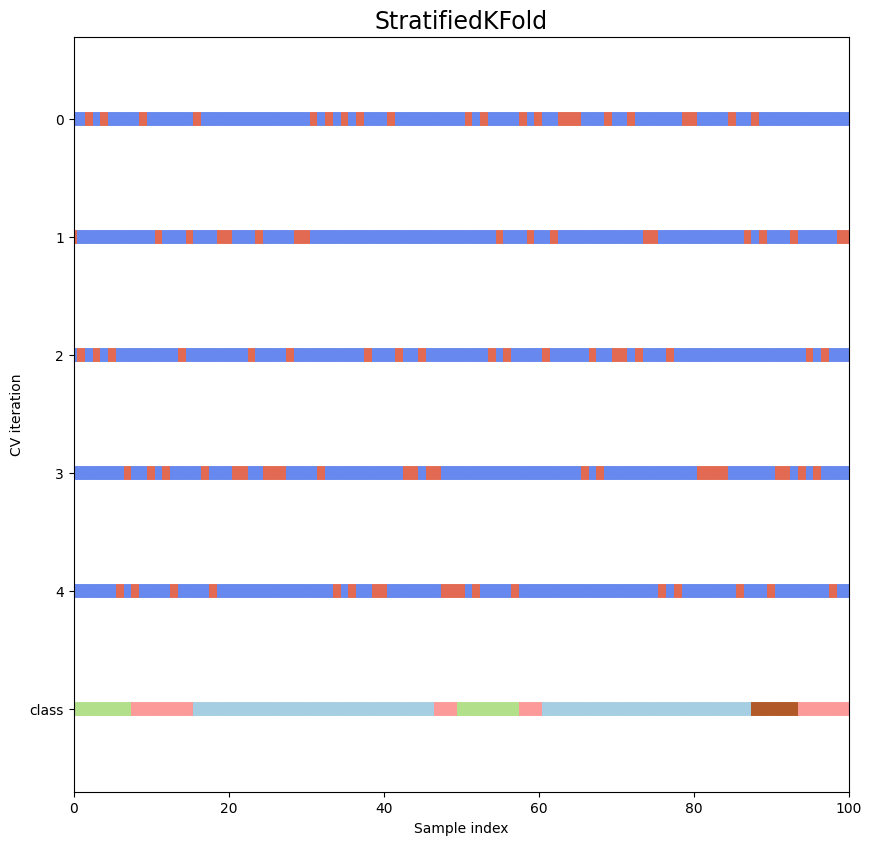

In [37]:
y = to_categorical(le.fit_transform(y_array))
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm


# visualize stratified cross-validation behavior
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y.argmax(1))):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y.argmax(1), marker='_', lw=lw, cmap=cmap_data)

#     ax.scatter(range(len(X)), [ii + 2.5] * len(X),
#                c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1.2, -.2], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=17)
    return ax


groups = np.hstack([[ii] * 10 for ii in range(10)])


fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
plot_cv_indices(skfold, X_array, y, groups, ax, n_splits=5)

In [8]:
# train best model (1 hidden layer with DP=0.2)
best_model = Sequential()

input_shape = (X_train.shape[1], X_train.shape[2])

best_model.add(LSTM(128, input_shape=input_shape))
best_model.add(Dropout(0.2))
best_model.add(Dense(128, activation="relu"))
best_model.add(Dropout(0.2))
best_model.add(Dense(num_outputs, activation="softmax"))

best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               86528     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 104,330
Trainable params: 104,330
Non-trainable params: 0
_________________________________________________________________


In [9]:
# define wrapper for Sequential model
def build_seq_model():

    best_model = Sequential()

    input_shape = (X_train.shape[1], X_train.shape[2])

    best_model.add(LSTM(128, input_shape=input_shape))
    best_model.add(Dropout(0.2))
    best_model.add(Dense(128, activation="relu"))
    best_model.add(Dropout(0.2))
    best_model.add(Dense(num_outputs, activation="softmax"))

    # initialize and compile
    opt = optimizers.Adam(learning_rate=0.001)
    best_model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=opt)

    return best_model

In [10]:
# get wrapper for Sequential model
sequential_clf = KerasClassifier(build_seq_model)

In [13]:
# evaluate scores of all models by cross-validation and get the mean
score = cross_val_score(sequential_clf, X_train, y_train, cv=skfold, scoring="accuracy")

print(f'\nPre training scores for each fold are:\n{score}\n')
print(f'Average score: {"{:.3f}".format(score.mean())}')

147/147 [==============================] - 2s 17ms/step - loss: 1.7702 - accuracy: 0.3542

Pre training scores for each fold are:
[0.52129472 0.54003407 0.51873935 0.51577153 0.50724638]

Average score: 0.521


In [17]:
# Define per-fold score containers
train_acc_per_fold = []
test_acc_per_fold = []
train_loss_per_fold = []
test_loss_per_fold = []

# save trainings of all models
histories = {}
durations = {}

# start training
for ite, (train_ix, test_ix) in enumerate(skfold.split(X_array, y_array)):

    # select rows
    X_train, X_test = X_array[train_ix], X_array[test_ix]
    y_train, y_test = y_array[train_ix], y_array[test_ix]

    # convert labels to 1-HOT array
    y_train = to_categorical(le.fit_transform(y_train))
    y_test = to_categorical(le.fit_transform(y_test))

    # transpose features to fit input shape of LSTM layer = schleife
    X_train = X_train.transpose(0, 2, 1)
    X_test = X_test.transpose(0, 2, 1)

    # build and compile the model
    model = build_seq_model()

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {ite+1} ...')

    # implement early stopping
    es = EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=50)
    start = datetime.now()

    histories[f"history_{ite}"] = model.fit(X_train,
                                            y_train,
                                            validation_data=(X_test, y_test),
                                            batch_size=256,
                                            epochs=1000,
                                            callbacks=[es],
                                            verbose=1)

    durations[f"duration_{ite}"] = datetime.now() - start

    # Generate generalization metrics
    train_evals = model.evaluate(X_train, y_train, verbose=1)
    test_evals = model.evaluate(X_test, y_test, verbose=1)

    print(f'Testing scores for fold {ite+1}: \
          {model.metrics_names[0]} of {test_evals[0]}; \
          {model.metrics_names[1]} of {test_evals[1]*100}%')

    print("Training completed in time: ", durations[f"duration_{ite}"])

    train_acc_per_fold.append(train_evals[1] * 100)
    test_acc_per_fold.append(test_evals[1] * 100)
    train_loss_per_fold.append(train_evals[0])
    test_loss_per_fold.append(test_evals[0])

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1000
23/23 [==============================] - 1s 38ms/step - loss: 2.0709 - accuracy: 0.2244 - val_loss: 1.7888 - val_accuracy: 0.3915
Epoch 2/1000
23/23 [==============================] - 1s 23ms/step - loss: 1.7161 - accuracy: 0.3756 - val_loss: 1.5470 - val_accuracy: 0.4475
Epoch 3/1000
23/23 [==============================] - 1s 25ms/step - loss: 1.4966 - accuracy: 0.4761 - val_loss: 1.3365 - val_accuracy: 0.5566
Epoch 4/1000
23/23 [==============================] - 1s 23ms/step - loss: 1.3132 - accuracy: 0.5527 - val_loss: 1.1962 - val_accuracy: 0.5900
Epoch 5/1000
23/23 [==============================] - 1s 24ms/step - loss: 1.1793 - accuracy: 0.5956 - val_loss: 1.0788 - val_accuracy: 0.6344
Epoch 6/1000
23/23 [==============================] - 1s 24ms/step - loss: 1.0637 - accuracy: 0.6406 - val_loss: 0.9831 - val_accuracy: 0.6569
Epoch 7/1000
23/23 [=========================

Epoch 114/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0632 - accuracy: 0.9802 - val_loss: 0.4729 - val_accuracy: 0.8820
Epoch 115/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0627 - accuracy: 0.9787 - val_loss: 0.4842 - val_accuracy: 0.8718
Epoch 116/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0895 - accuracy: 0.9709 - val_loss: 0.4989 - val_accuracy: 0.8718
Epoch 117/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0897 - accuracy: 0.9688 - val_loss: 0.5077 - val_accuracy: 0.8745
Epoch 118/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0803 - accuracy: 0.9732 - val_loss: 0.5245 - val_accuracy: 0.8745
Epoch 119/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0748 - accuracy: 0.9743 - val_loss: 0.4945 - val_accuracy: 0.8806
Epoch 120/1000
23/23 [==============================] - 1s 23ms/step - loss: 0.0691 - accuracy: 0.9734 - val_loss: 0.5166 - val_ac

23/23 [==============================] - 1s 24ms/step - loss: 0.0403 - accuracy: 0.9870 - val_loss: 0.4660 - val_accuracy: 0.8990
Epoch 227/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0378 - accuracy: 0.9865 - val_loss: 0.5045 - val_accuracy: 0.8765
Epoch 228/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0424 - accuracy: 0.9852 - val_loss: 0.5210 - val_accuracy: 0.8854
Epoch 229/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0304 - accuracy: 0.9903 - val_loss: 0.4614 - val_accuracy: 0.8984
Epoch 230/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0506 - accuracy: 0.9840 - val_loss: 0.5484 - val_accuracy: 0.8874
Epoch 231/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0423 - accuracy: 0.9852 - val_loss: 0.5566 - val_accuracy: 0.8840
Epoch 232/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0323 - accuracy: 0.9891 - val_loss: 0.5258 - val_accuracy: 0.8915


Epoch 21/1000
23/23 [==============================] - 1s 23ms/step - loss: 0.4553 - accuracy: 0.8381 - val_loss: 0.5143 - val_accuracy: 0.8206
Epoch 22/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.4396 - accuracy: 0.8499 - val_loss: 0.4818 - val_accuracy: 0.8363
Epoch 23/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.3991 - accuracy: 0.8642 - val_loss: 0.4827 - val_accuracy: 0.8377
Epoch 24/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.3870 - accuracy: 0.8676 - val_loss: 0.4744 - val_accuracy: 0.8370
Epoch 25/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.3686 - accuracy: 0.8727 - val_loss: 0.4508 - val_accuracy: 0.8465
Epoch 26/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.3595 - accuracy: 0.8730 - val_loss: 0.4498 - val_accuracy: 0.8458
Epoch 27/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.3444 - accuracy: 0.8839 - val_loss: 0.4517 - val_accuracy:

Epoch 78/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.1168 - accuracy: 0.9600 - val_loss: 0.4383 - val_accuracy: 0.8799
Epoch 79/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.1035 - accuracy: 0.9634 - val_loss: 0.4285 - val_accuracy: 0.8868
Epoch 80/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.1249 - accuracy: 0.9547 - val_loss: 0.4339 - val_accuracy: 0.8786
Epoch 81/1000
23/23 [==============================] - 1s 23ms/step - loss: 0.1019 - accuracy: 0.9630 - val_loss: 0.4468 - val_accuracy: 0.8888
Epoch 82/1000
23/23 [==============================] - 1s 23ms/step - loss: 0.0937 - accuracy: 0.9697 - val_loss: 0.4400 - val_accuracy: 0.8854
Epoch 83/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0977 - accuracy: 0.9659 - val_loss: 0.4446 - val_accuracy: 0.8772
Epoch 84/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.1074 - accuracy: 0.9601 - val_loss: 0.4495 - val_accuracy:

23/23 [==============================] - 1s 22ms/step - loss: 0.0332 - accuracy: 0.9898 - val_loss: 0.4963 - val_accuracy: 0.8977
Epoch 191/1000
23/23 [==============================] - 0s 21ms/step - loss: 0.0421 - accuracy: 0.9865 - val_loss: 0.5063 - val_accuracy: 0.8963
Epoch 192/1000
23/23 [==============================] - 1s 22ms/step - loss: 0.0375 - accuracy: 0.9869 - val_loss: 0.5094 - val_accuracy: 0.8902
Epoch 193/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0435 - accuracy: 0.9869 - val_loss: 0.5243 - val_accuracy: 0.8888
Epoch 194/1000
23/23 [==============================] - 1s 23ms/step - loss: 0.0480 - accuracy: 0.9835 - val_loss: 0.4553 - val_accuracy: 0.8977
Epoch 195/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0491 - accuracy: 0.9828 - val_loss: 0.5356 - val_accuracy: 0.8950
Epoch 196/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0439 - accuracy: 0.9835 - val_loss: 0.4814 - val_accuracy: 0.8990


Epoch 28/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.3553 - accuracy: 0.8776 - val_loss: 0.4791 - val_accuracy: 0.8411
Epoch 29/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.3335 - accuracy: 0.8858 - val_loss: 0.4649 - val_accuracy: 0.8506
Epoch 30/1000
23/23 [==============================] - 1s 23ms/step - loss: 0.3499 - accuracy: 0.8766 - val_loss: 0.4851 - val_accuracy: 0.8411
Epoch 31/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.3094 - accuracy: 0.8920 - val_loss: 0.4499 - val_accuracy: 0.8547
Epoch 32/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.3009 - accuracy: 0.8964 - val_loss: 0.4523 - val_accuracy: 0.8554
Epoch 33/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.2888 - accuracy: 0.8959 - val_loss: 0.4530 - val_accuracy: 0.8452
Epoch 34/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.2828 - accuracy: 0.9034 - val_loss: 0.4483 - val_accuracy:

Epoch 85/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.1073 - accuracy: 0.9652 - val_loss: 0.4554 - val_accuracy: 0.8731
Epoch 86/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.1029 - accuracy: 0.9646 - val_loss: 0.4534 - val_accuracy: 0.8718
Epoch 87/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.1030 - accuracy: 0.9647 - val_loss: 0.4276 - val_accuracy: 0.8874
Epoch 88/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.1022 - accuracy: 0.9663 - val_loss: 0.4448 - val_accuracy: 0.8683
Epoch 89/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0963 - accuracy: 0.9649 - val_loss: 0.4486 - val_accuracy: 0.8827
Epoch 90/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0913 - accuracy: 0.9678 - val_loss: 0.4482 - val_accuracy: 0.8772
Epoch 91/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0889 - accuracy: 0.9685 - val_loss: 0.4464 - val_accuracy:

23/23 [==============================] - 1s 26ms/step - loss: 0.5780 - accuracy: 0.8061 - val_loss: 0.6402 - val_accuracy: 0.7769
Epoch 17/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.5475 - accuracy: 0.8096 - val_loss: 0.6233 - val_accuracy: 0.7865
Epoch 18/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.5142 - accuracy: 0.8250 - val_loss: 0.5978 - val_accuracy: 0.7981
Epoch 19/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.5075 - accuracy: 0.8241 - val_loss: 0.5847 - val_accuracy: 0.8117
Epoch 20/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.4685 - accuracy: 0.8388 - val_loss: 0.5566 - val_accuracy: 0.8022
Epoch 21/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.4550 - accuracy: 0.8449 - val_loss: 0.5421 - val_accuracy: 0.8111
Epoch 22/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.4236 - accuracy: 0.8613 - val_loss: 0.5430 - val_accuracy: 0.8117
Epoch 

Epoch 73/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.1138 - accuracy: 0.9623 - val_loss: 0.4635 - val_accuracy: 0.8704
Epoch 74/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.1068 - accuracy: 0.9615 - val_loss: 0.4916 - val_accuracy: 0.8622
Epoch 75/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.1094 - accuracy: 0.9628 - val_loss: 0.5121 - val_accuracy: 0.8595
Epoch 76/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0984 - accuracy: 0.9654 - val_loss: 0.4606 - val_accuracy: 0.8752
Epoch 77/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.1113 - accuracy: 0.9646 - val_loss: 0.5034 - val_accuracy: 0.8649
Epoch 78/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.1058 - accuracy: 0.9644 - val_loss: 0.4824 - val_accuracy: 0.8656
Epoch 79/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.1006 - accuracy: 0.9652 - val_loss: 0.4810 - val_accuracy:

Epoch 130/1000
23/23 [==============================] - 0s 20ms/step - loss: 0.0449 - accuracy: 0.9850 - val_loss: 0.4918 - val_accuracy: 0.8847
Epoch 131/1000
23/23 [==============================] - 0s 20ms/step - loss: 0.0390 - accuracy: 0.9855 - val_loss: 0.5228 - val_accuracy: 0.8874
Epoch 132/1000
23/23 [==============================] - 0s 21ms/step - loss: 0.0409 - accuracy: 0.9876 - val_loss: 0.4785 - val_accuracy: 0.8895
Epoch 133/1000
23/23 [==============================] - 0s 21ms/step - loss: 0.0433 - accuracy: 0.9843 - val_loss: 0.5310 - val_accuracy: 0.8840
Epoch 134/1000
23/23 [==============================] - 0s 20ms/step - loss: 0.0454 - accuracy: 0.9840 - val_loss: 0.5132 - val_accuracy: 0.8827
Epoch 135/1000
23/23 [==============================] - 0s 20ms/step - loss: 0.0459 - accuracy: 0.9840 - val_loss: 0.5339 - val_accuracy: 0.8813
Epoch 136/1000
23/23 [==============================] - 1s 22ms/step - loss: 0.0479 - accuracy: 0.9823 - val_loss: 0.5170 - val_ac

Epoch 18/1000
23/23 [==============================] - 1s 23ms/step - loss: 0.4767 - accuracy: 0.8376 - val_loss: 0.5709 - val_accuracy: 0.8131
Epoch 19/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.4413 - accuracy: 0.8516 - val_loss: 0.5445 - val_accuracy: 0.8199
Epoch 20/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.4220 - accuracy: 0.8574 - val_loss: 0.5296 - val_accuracy: 0.8247
Epoch 21/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.4044 - accuracy: 0.8604 - val_loss: 0.5207 - val_accuracy: 0.8295
Epoch 22/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.3948 - accuracy: 0.8698 - val_loss: 0.5133 - val_accuracy: 0.8261
Epoch 23/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.3654 - accuracy: 0.8804 - val_loss: 0.4994 - val_accuracy: 0.8274
Epoch 24/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.3551 - accuracy: 0.8795 - val_loss: 0.4907 - val_accuracy:

Epoch 75/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0883 - accuracy: 0.9703 - val_loss: 0.4370 - val_accuracy: 0.8779
Epoch 76/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0830 - accuracy: 0.9705 - val_loss: 0.4558 - val_accuracy: 0.8629
Epoch 77/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0792 - accuracy: 0.9749 - val_loss: 0.4533 - val_accuracy: 0.8772
Epoch 78/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0782 - accuracy: 0.9753 - val_loss: 0.4380 - val_accuracy: 0.8731
Epoch 79/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0862 - accuracy: 0.9717 - val_loss: 0.4285 - val_accuracy: 0.8718
Epoch 80/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0867 - accuracy: 0.9693 - val_loss: 0.4520 - val_accuracy: 0.8697
Epoch 81/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0877 - accuracy: 0.9719 - val_loss: 0.4968 - val_accuracy:

Epoch 132/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0409 - accuracy: 0.9869 - val_loss: 0.4243 - val_accuracy: 0.8943
Epoch 133/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0392 - accuracy: 0.9860 - val_loss: 0.4374 - val_accuracy: 0.8943
Epoch 134/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0332 - accuracy: 0.9898 - val_loss: 0.4222 - val_accuracy: 0.8956
Epoch 135/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0393 - accuracy: 0.9857 - val_loss: 0.4740 - val_accuracy: 0.8874
Epoch 136/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0565 - accuracy: 0.9792 - val_loss: 0.4581 - val_accuracy: 0.8902
Epoch 137/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0625 - accuracy: 0.9806 - val_loss: 0.4906 - val_accuracy: 0.8922
Epoch 138/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0548 - accuracy: 0.9809 - val_loss: 0.4595 - val_ac

In [21]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold\n')

for i in range(0, folds):
    print(f'> Fold {i+1} - Loss: {train_loss_per_fold[i]:.4f} - Training Accuracy: {train_acc_per_fold[i]:.4f} %')
    print(f'> Fold {i+1} - Loss: {test_loss_per_fold[i]:.4f} - Testing Accuracy: {test_acc_per_fold[i]:.4f} %\n')

print('------------------------------------------------------------------------')
print('Average scores for all folds:\n')
print(f'> Training Accuracy: {np.mean(train_acc_per_fold):.4f} % (+- {np.std(train_acc_per_fold):.4f})')
print(f'> Testing Accuracy: {np.mean(test_acc_per_fold):.4f} % (+- {np.std(test_acc_per_fold):.4f})')
print(f'> Loss: {np.mean(test_loss_per_fold):.4f}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold

> Fold 1 - Loss: 0.0034 - Training Accuracy: 99.9489 %
> Fold 1 - Loss: 0.5638 - Testing Accuracy: 89.1542 %

> Fold 2 - Loss: 0.0054 - Training Accuracy: 99.8637 %
> Fold 2 - Loss: 0.4994 - Testing Accuracy: 88.6085 %

> Fold 3 - Loss: 0.0112 - Training Accuracy: 99.6762 %
> Fold 3 - Loss: 0.5829 - Testing Accuracy: 87.3806 %

> Fold 4 - Loss: 0.0034 - Training Accuracy: 99.9659 %
> Fold 4 - Loss: 0.5763 - Testing Accuracy: 88.2674 %

> Fold 5 - Loss: 0.0114 - Training Accuracy: 99.6251 %
> Fold 5 - Loss: 0.5390 - Testing Accuracy: 89.2224 %

------------------------------------------------------------------------
Average scores for all folds:

> Training Accuracy: 99.8160 % (+- 0.1403)
> Testing Accuracy: 88.5266 % (+- 0.6731)
> Loss: 0.5523
------------------------------------------------------------------------


 Plots for Model 1


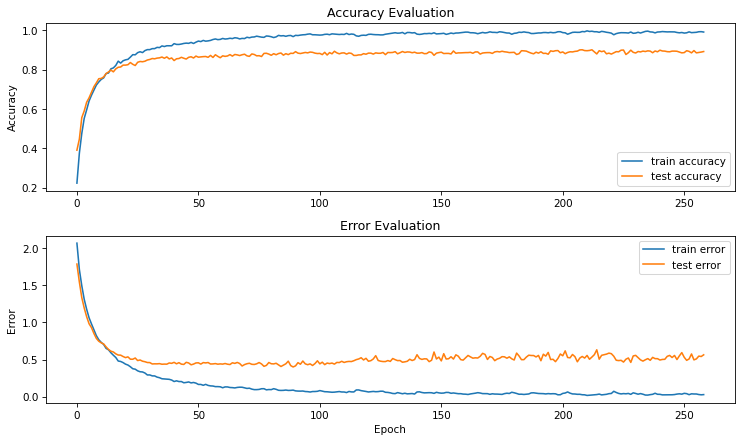

 Plots for Model 2


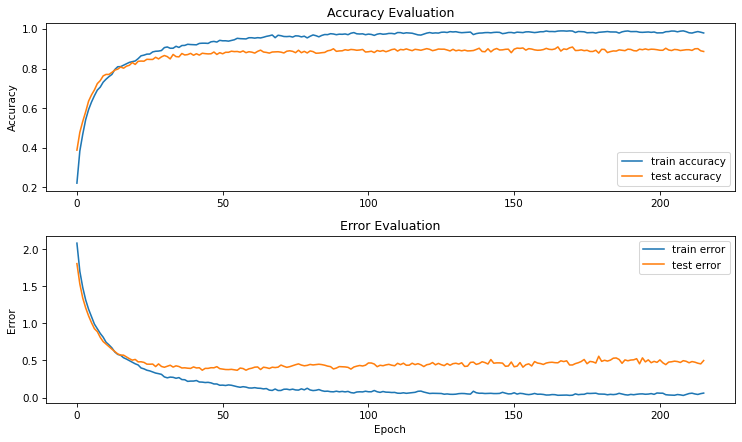

 Plots for Model 3


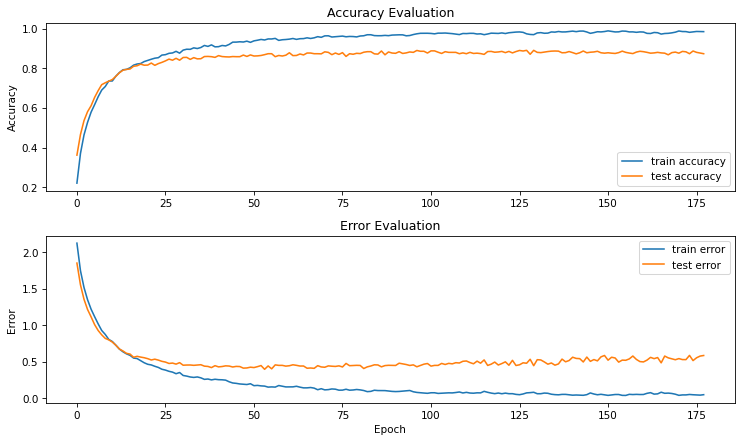

 Plots for Model 4


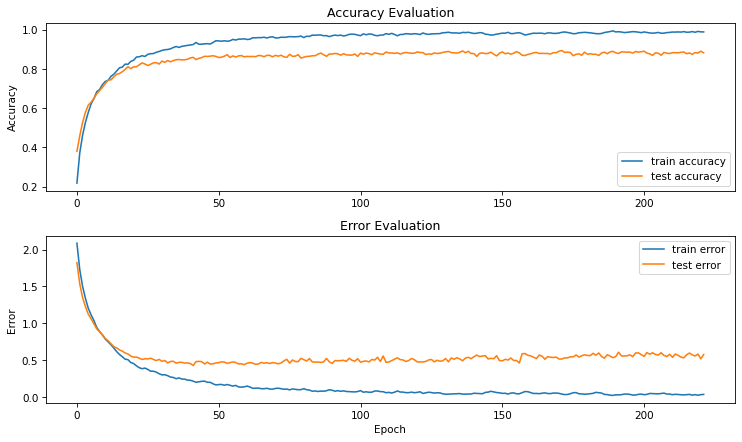

 Plots for Model 5


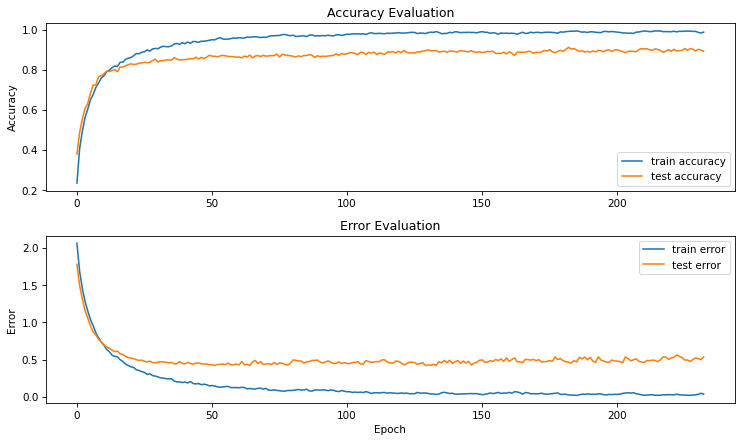

In [22]:
# plot
def plot_histories(fold):

    fig, axs = plt.subplots(2, figsize=(10, 6), dpi=75)

    axs[0].plot(histories[f"history_{fold}"].history["accuracy"], label="train accuracy")
    axs[0].plot(histories[f"history_{fold}"].history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Evaluation")

    # Error subplot
    axs[1].plot(histories[f"history_{fold}"].history["loss"], label="train error")
    axs[1].plot(histories[f"history_{fold}"].history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Evaluation")

    plt.tight_layout()
    plt.show()


for fold in range(folds):

    print(f" Plots for Model {fold+1}")
    plot_histories(fold)

In [30]:
def accuracies_vs_models(folds):

    width = 0.15

    # Training / Testing accuracies vs models
    ticks = np.arange(1, folds + 1)

    fig, ax = plt.subplots(figsize=(12, 6), dpi=85)
    ax.bar(ticks - width/2, train_acc_per_fold, width, label='Train Accuracy')
    ax.bar(ticks + width/2, test_acc_per_fold, width, label='Test Accuracy')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracies')
    ax.set_xlabel("Folds")
    ax.set_title('Accuracies vs Folds')
    ax.set_xticks(ticks)
    ax.legend(loc="lower right")

    for i, v in enumerate(train_acc_per_fold):
        plt.annotate(str(np.round(v, 4)), xy=(
            ticks[i], train_acc_per_fold[i]), ha='left',
                va='bottom', xytext=(-50, 3), textcoords="offset points")

    for i, v in enumerate(test_acc_per_fold):
        plt.annotate(str(np.round(v, 4)),  xy=(
            ticks[i], test_acc_per_fold[i]), ha='center',
                va='bottom', xytext=(50, 3), textcoords="offset points")

    plt.tight_layout()
    plt.show()

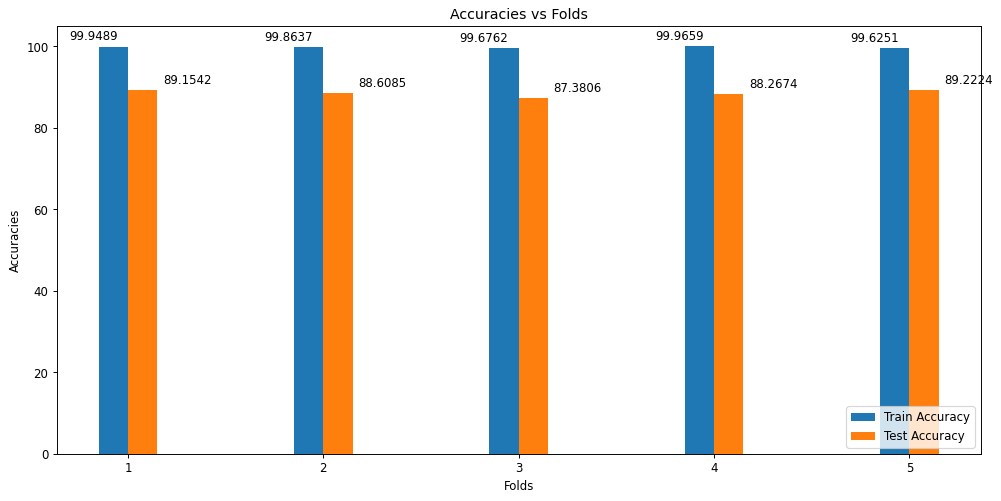

In [31]:
accuracies_vs_models(folds)